In [33]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler



countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

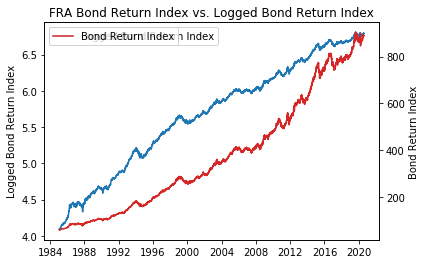

In [34]:
# Bond return setup
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()

average = 'Equal Weighted Mean'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1)

country = 'FRA'

# Visualizing Bond Return Index vs. Logged Bond Return Index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Logged Bond Return Index'
ax1.plot(np.log(BondReturnIndex[country]).to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Return Index vs. Logged Bond Return Index')
plt.show()

# Indicator 1: Bond Premium

* What it is: difference between the long rate and short rate
* What it means: reflects the slope of the yield curve
* What it tells us: the greater the bond premium, the greater the spread between long and short rates
* What we expect: typically the bond premium is positive (meaning that long rates > short rates) since there is more risk associated with holding bonds for longer
* What this tells us about bonds: steepening yield curves attracts investors with long positions

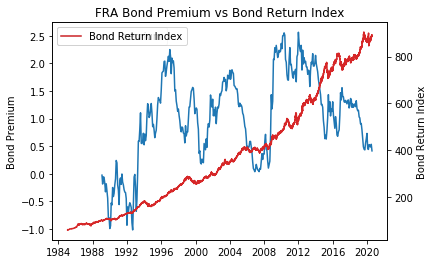

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA,Equal Weighted Mean
date,,,,,,,,,,,
2020-04,0.472,0.183,0.220,0.845,0.528,1.135,0.141,0.235,0.197,0.401,0.4357
2020-05,0.668,0.173,0.195,0.838,0.501,1.252,0.132,0.108,0.213,0.438,0.4518
2020-06,0.619,0.260,0.250,0.988,0.486,1.126,0.170,0.214,0.233,0.504,0.4850
2020-07,0.660,0.260,0.241,1.000,0.534,1.236,0.186,0.255,0.274,0.518,0.5164
2020-08,0.583,0.177,0.205,0.713,0.415,1.097,0.158,0.260,0.174,0.448,0.4230


In [35]:
ShortRates = dl.pull('ShortRates') # monthly
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds

BondPremium = LongRates - ShortRates # reflects the slope of the yield curve
BondPremium[average] = BondPremium.mean(axis=1)

# Bond Premium vs. Bond Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Return Index')
plt.show()

BondPremium.tail()

In [64]:
def BondPremiumIndicator(country):
    
    # Set up results table with weekday rows
    countryData = pd.DataFrame(BondReturnIndex[country])
    
    # Rolling past 6 months for country and global equal weighted average
    rolling6MBondPremium = BondPremium[country].rolling(6).mean()
    rolling6MBondPremiumAvg = BondPremium[average].rolling(6).mean()
    
    # Rolling past 12 months for country and global equal weighted average
    rolling12MBondPremium = BondPremium[country].rolling(12).mean()
    rolling12MBondPremiumAvg = BondPremium[average].rolling(12).mean()
    
    # Upsampled monthly bond premium measures to daily before inserting
    countryData['Bond Premium'] = BondPremium[country].resample('B').ffill()
    countryData['6M Rolling BP'] = rolling6MBondPremium.resample('B').ffill()
    countryData['6M Rolling BP Avg'] = rolling6MBondPremiumAvg.resample('B').ffill()
    countryData['12M Rolling BP'] = rolling12MBondPremium.resample('B').ffill()
    countryData['12M Rolling BP Avg'] = rolling12MBondPremiumAvg.resample('B').ffill() 
    
    # Simple prediction looks only at bond premium and scales it
    scaler = MinMaxScaler()
    countryData['Prediction'] = scaler.fit_transform(countryData['Bond Premium'].values.reshape(-1,1))
    ### Trying a few things because my normalizing is getting me between 0 and 1 (not -1 and 1)
    
    #countryData['Prediction'] =  countryData['Prediction'] - countryData['Prediction'].min()
    #countryData['Prediction'] /=  countryData['Prediction'].max()

    prediction = scaler.fit_transform(countryData['Bond Premium'])
    prediction -= prediction.min()
    print(prediction)
                                                     
    ## Better prediction would add in data to get value in local and global context
    countryData['P&L'] = countryData['Prediction'] * countryData[country].shift(1).pct_change()
    
    countryData['P&L'].cumsum().plot()
    plt.title(f'{country} P&L Curve using Bond Premium indicator')
    plt.show()

    return countryData

results = BondPremiumIndicator('FRA')
print(results['Prediction'].max())



AttributeError: 'PandasArray' object has no attribute 'reshape'